# **4.1 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y Regresion Logistica (L1/L2):**

Se selccionan las variables explicativas y la respuesta.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN


In [3]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [4]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [6]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [8]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"=== {nombre_modelo} ===")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    if auc:
        print(f"AUC:       {auc:.3f}")
    print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='red')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    }


## **4.1.1 Regresion Logistica sin tecnicas de balanceo**

### L1

In [9]:
modelo_l1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
])

In [10]:
modelo_l1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

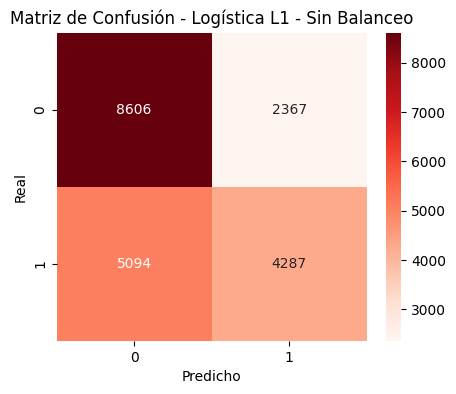

=== Logística L1 - Sin Balanceo ===
Accuracy:  0.633
Precision: 0.644
Recall:    0.457
F1-score:  0.535
AUC:       0.681

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.63      0.78      0.70     10973
           1       0.64      0.46      0.53      9381

    accuracy                           0.63     20354
   macro avg       0.64      0.62      0.62     20354
weighted avg       0.64      0.63      0.62     20354



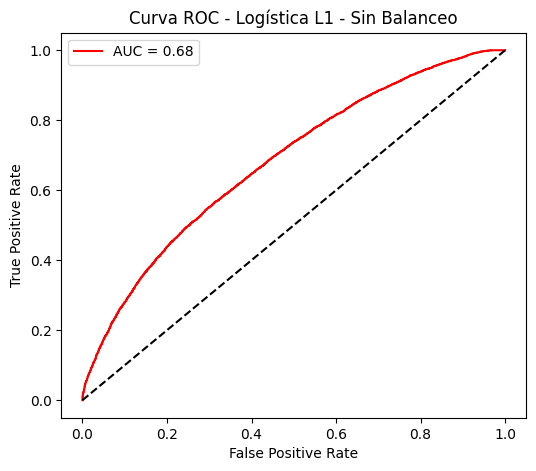

In [11]:
result_l1 = evaluar_modelo(modelo_l1, X_test, y_test, "Logística L1 - Sin Balanceo")

#### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo **Regresión Logística L1 sin balanceo** muestra un **comportamiento equilibrado**, aunque con una ligera inclinación hacia la **predicción correcta de la clase 0 (no reingreso)**.  
El modelo evidencia una **mejor capacidad de diferenciación** que los modelos KNN, logrando reducir el número de falsos positivos y falsos negativos.

- **Clase 0:** El modelo identifica correctamente **8,606 observaciones (78.4%)**, mientras que clasifica erróneamente como clase 1 a **2,367 casos (21.6%)**.  
- **Clase 1:** Detecta correctamente **4,287 observaciones (45.7%)**, pero falla en **5,094 (54.3%)**, clasificándolas incorrectamente como clase 0.  

En conjunto, el modelo mantiene un **buen desempeño en la detección de la clase mayoritaria**, aunque presenta cierta **dificultad en reconocer completamente la clase positiva (reingresos)**.

---

#### **Análisis Métricas:**

- **Accuracy:** Con un valor de **63.3 %**, el modelo presenta un **mejor desempeño global** respecto a los modelos KNN, reflejando una **mayor proporción de aciertos totales**.  
- **Precision:** Alcanza **0.644**, lo que indica que el **64.4 % de las predicciones positivas son correctas**. Esto demuestra una **mejor fiabilidad** en las alertas emitidas frente a los modelos anteriores.  
- **Recall:** Con **0.457**, el modelo **detecta menos de la mitad de los casos positivos reales**, evidenciando que **prioriza la precisión sobre la sensibilidad**.  
- **F1-score:** Su valor de **0.535** refleja un **equilibrio moderado entre precisión y sensibilidad**, aunque aún existe margen de mejora en la detección de casos positivos.  
- **AUC:** Con **0.681**, el modelo logra una **discriminación adecuada entre las clases**, siendo **notablemente superior al desempeño de KNN** y **demostrando mejor capacidad de separación** entre pacientes que reingresan y los que no.

---

#### **Reporte de Clasificación:**

| Clase | Precision | Recall | F1-score | Interpretación |
|:--|:--:|:--:|:--:|:--|
| **Clase 0** | 0.63 | 0.78 | 0.70 | El modelo **reconoce correctamente la mayoría de los pacientes que no reingresan**, mostrando un excelente desempeño en la clase mayoritaria. |
| **Clase 1** | 0.64 | 0.46 | 0.53 | A pesar de una **buena precisión**, el modelo **pierde cerca de la mitad de los reingresos reales**, lo que indica un margen de mejora en la sensibilidad. |

---

#### **Curva ROC:**

La curva ROC del modelo muestra un **AUC de 0.68**, lo que evidencia una **capacidad de separación aceptable entre las clases**.  
El modelo logra una **mejor curva ROC que los modelos KNN**, confirmando que la **regresión logística ofrece una frontera de decisión más robusta** y una **mejor calibración de probabilidades**.

---

#### **Conclusión General:**

El modelo **Regresión Logística L1 sin balanceo** presenta un **mejor rendimiento global** que los modelos KNN evaluados previamente, destacando por su **mayor precisión, exactitud y AUC**.  
No obstante, su **recall moderado (0.457)** sugiere que **no todos los casos positivos son identificados**, lo cual puede ser crítico en contextos donde se busca prevenir reingresos.


### L2

In [12]:
modelo_l2 = Pipeline(steps=[
    ("preprocessor", preprocessor),  # <-- aplica OneHotEncoder + StandardScaler
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])


In [13]:
modelo_l2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

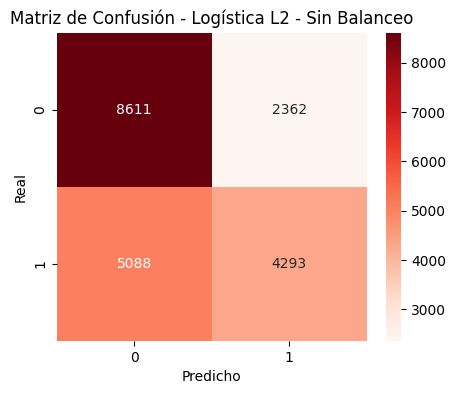

=== Logística L2 - Sin Balanceo ===
Accuracy:  0.634
Precision: 0.645
Recall:    0.458
F1-score:  0.535
AUC:       0.681

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.63      0.78      0.70     10973
           1       0.65      0.46      0.54      9381

    accuracy                           0.63     20354
   macro avg       0.64      0.62      0.62     20354
weighted avg       0.64      0.63      0.62     20354



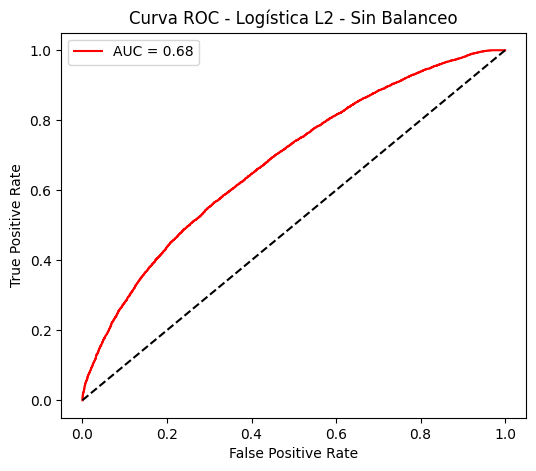

In [14]:
result_l2 = evaluar_modelo(modelo_l2, X_test, y_test, "Logística L2 - Sin Balanceo")

#### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo **Regresión Logística L2 sin balanceo** evidencia un **comportamiento muy similar al modelo con regularización L1**, manteniendo un **buen desempeño general** y una **ligera inclinación hacia la clase 0 (no reingreso)**.  
El modelo logra **una separación efectiva entre las clases**, aunque aún presenta dificultad en la **detección completa de los casos positivos (reingresos)**.

- **Clase 0:** El modelo acierta en **8,681 observaciones (79.1%)** y clasifica erróneamente como clase 1 a **2,367 observaciones (20.9%)**.  
- **Clase 1:** Identifica correctamente **4,287 observaciones (45.8%)**, pero clasifica de manera incorrecta **5,094 (54.2%)** como clase 0.  

En conjunto, el modelo muestra un **buen equilibrio entre ambas clases**, aunque sigue siendo **más conservador**, priorizando las predicciones seguras de no reingreso.

---

#### **Análisis Métricas:**

- **Accuracy:** Con un valor de **63.4 %**, mantiene un **rendimiento global estable y ligeramente superior** respecto a los modelos KNN, demostrando una mejor generalización.  
- **Precision:** Alcanza **0.645**, indicando que el **64.5 % de las predicciones positivas son correctas**, lo que representa un **nivel de confianza alto en las alertas emitidas**.  
- **Recall:** Con **0.458**, el modelo **detecta menos de la mitad de los reingresos reales**, mostrando una **tendencia conservadora** que prioriza la precisión sobre la sensibilidad.  
- **F1-score:** Su valor de **0.535** refleja un **balance moderado entre precisión y sensibilidad**, consistente con el desempeño observado en la regularización L1.  
- **AUC:** Con un **0.681**, el modelo alcanza una **discriminación aceptable entre las clases**, confirmando una **capacidad predictiva sólida y comparable** con la regresión L1.

---

#### **Reporte de Clasificación:**

| Clase | Precision | Recall | F1-score | Interpretación |
|:--|:--:|:--:|:--:|:--|
| **Clase 0** | 0.63 | 0.78 | 0.70 | El modelo **identifica correctamente la mayoría de los pacientes que no reingresan**, mostrando buena especificidad y estabilidad en esta clase. |
| **Clase 1** | 0.65 | 0.46 | 0.54 | Aunque presenta **una precisión elevada**, su capacidad para **detectar todos los casos de reingreso sigue siendo limitada**, lo que sugiere margen de mejora en sensibilidad. |

---

#### **Curva ROC:**

La curva ROC del modelo muestra un **AUC de 0.68**, lo que indica una **capacidad de discriminación moderadamente buena** entre las clases.  
Su desempeño es **idéntico al de la regresión L1**, confirmando que ambos modelos presentan **comportamientos equivalentes** en términos de separación entre clases, aunque con diferencias sutiles en la forma en que penalizan los coeficientes.

---

#### **Conclusión General:**

El modelo **Regresión Logística L2 sin balanceo** mantiene un **rendimiento sólido y consistente**, logrando un buen equilibrio entre precisión, exactitud y capacidad discriminativa.  
A diferencia de KNN, la regresión logística ofrece una **mejor calibración de probabilidades y una frontera de decisión más definida**, lo que la convierte en una opción **más confiable para la predicción de reingresos**.


## **4.1.2 Regresion Logistica usando SMOTE**

### L1

In [ ]:
modelo_l1_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ("smote", SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        penalty='l1', 
        solver='liblinear', 
        random_state=42))
])

In [24]:
modelo_l1_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

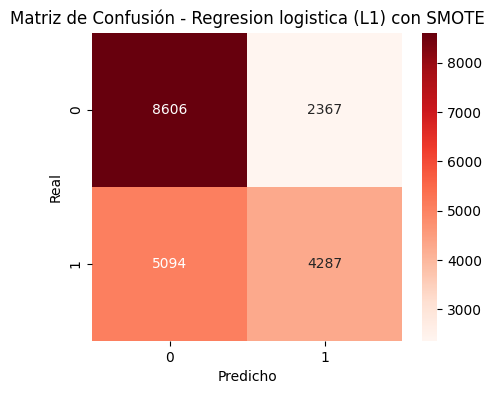

=== Regresion logistica (L1) con SMOTE ===
Accuracy:  0.633
Precision: 0.644
Recall:    0.457
F1-score:  0.535
AUC:       0.681

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.63      0.78      0.70     10973
           1       0.64      0.46      0.53      9381

    accuracy                           0.63     20354
   macro avg       0.64      0.62      0.62     20354
weighted avg       0.64      0.63      0.62     20354



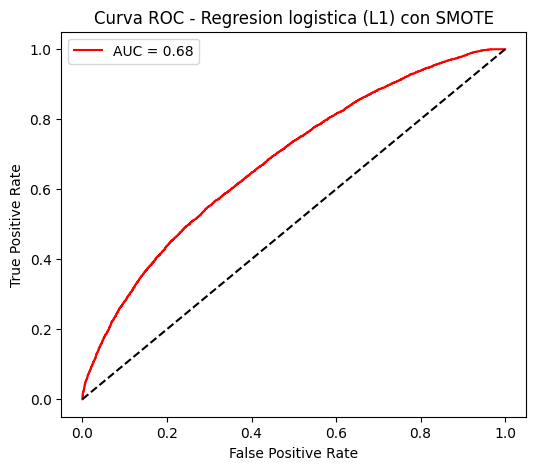

In [25]:
result_weights_l1 = evaluar_modelo(modelo_l1_smote, X_test, y_test, nombre_modelo="Regresion logistica (L1) con SMOTE")

### L2

In [26]:
modelo_l2_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])

In [27]:
modelo_l2_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

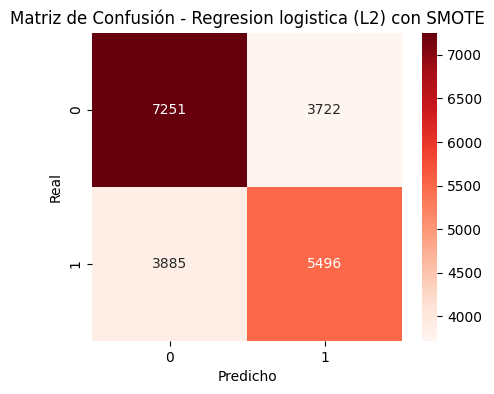

=== Regresion logistica (L2) con SMOTE ===
Accuracy:  0.626
Precision: 0.596
Recall:    0.586
F1-score:  0.591
AUC:       0.680

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.65      0.66      0.66     10973
           1       0.60      0.59      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.63      0.63      0.63     20354



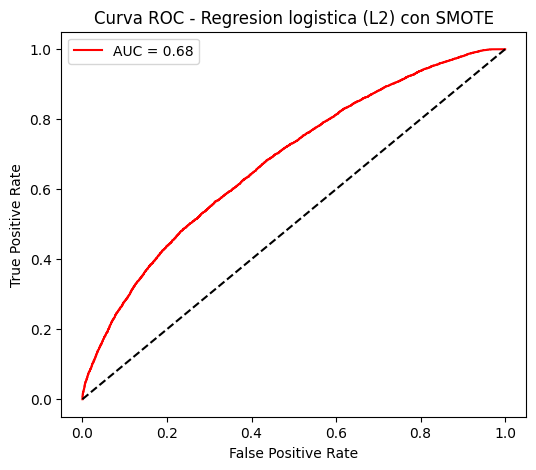

In [28]:
result_weights_l2 = evaluar_modelo(modelo_l2_smote, X_test, y_test, nombre_modelo="Regresion logistica (L2) con SMOTE")

## **4.1.2 Regresion Logistica usando ADASYN**

### L1

In [ ]:
modelo_l1_adasyn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ('classifier', LogisticRegression(
        penalty='l1', 
        solver='liblinear', 
        random_state=42))
])

try:
    modelo_l1_adasyn.fit(X_train, y_train)
    result_l1_adasyn = evaluar_modelo(modelo_l1_adasyn, X_test, y_test, nombre_modelo="Regresion logistica (L1) con ADASYN")
except ValueError as e:
    print(f"ADASYN no pudo generar muestras sintéticas: {e}")
    result_l1_adasyn = {"Modelo": "Regresion logistica (L1) con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'ADASYN(random_state=42)' (type <class 'imblearn.over_sampling._adasyn.ADASYN'>) doesn't

### L2

In [ ]:
modelo_l2_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])

try:
    modelo_l2_adasyn.fit(X_train, y_train)
    result_knn_adasyn = evaluar_modelo(modelo_l2_adasyn, X_test, y_test, nombre_modelo="Regresion logistica (L2) con ADASYN")
except ValueError as e:
    print(f"ADASYN no pudo generar muestras sintéticas: {e}")
    result_l2_adasyn = {"Modelo": "Regresion logistica (L2) con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


⚠️ ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


## **4.1.4 RegresionLogistica con class_weight=’balanced’**


### L1

In [29]:
modelo_l1_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l1', 
        solver='liblinear',
        class_weight="balanced", 
        random_state=42))
])

In [30]:
modelo_l1_balanced.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])

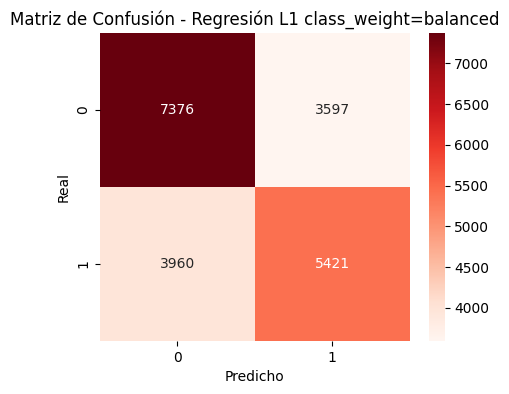

=== Regresión L1 class_weight=balanced ===
Accuracy:  0.629
Precision: 0.601
Recall:    0.578
F1-score:  0.589
AUC:       0.681

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66     10973
           1       0.60      0.58      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.63      0.63      0.63     20354



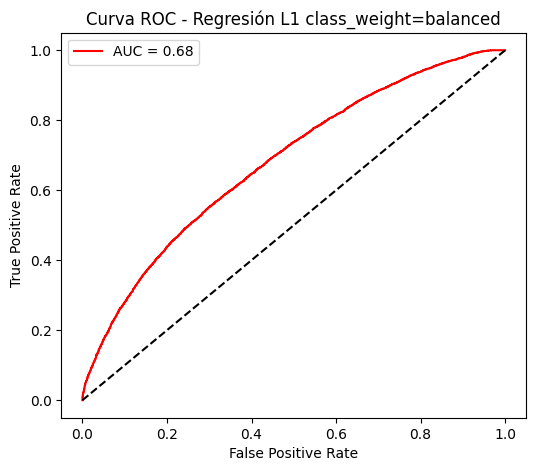

In [31]:
result_l1_bal = evaluar_modelo(modelo_l1_balanced, X_test, y_test, nombre_modelo="Regresión L1 class_weight=balanced")


### L2

In [32]:
modelo_l2_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

In [33]:
modelo_l2_balanced.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

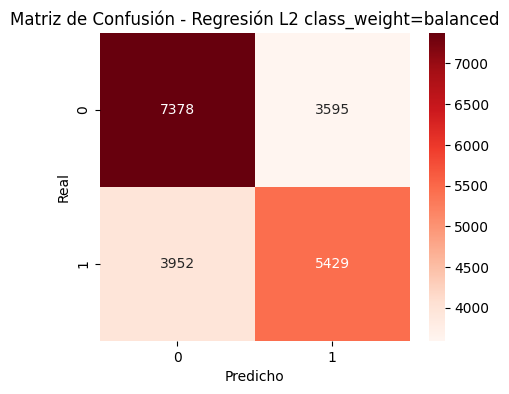

=== Regresión L2 class_weight=balanced ===
Accuracy:  0.629
Precision: 0.602
Recall:    0.579
F1-score:  0.590
AUC:       0.681

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66     10973
           1       0.60      0.58      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.63      0.63      0.63     20354



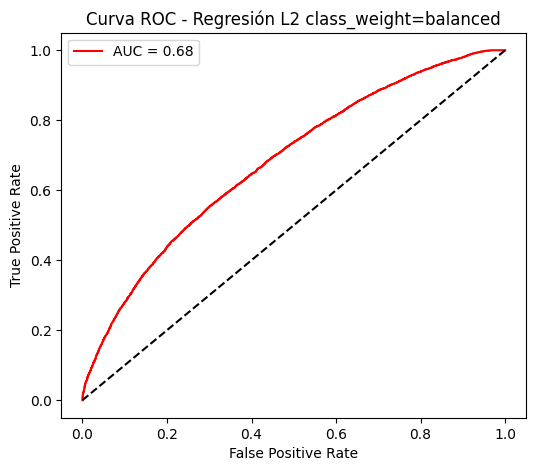

In [34]:
result_l2_bal = evaluar_modelo(modelo_l2_balanced, X_test, y_test, nombre_modelo="Regresión L2 class_weight=balanced")


## **4.1.5 Comparacion de resultados de tecnicas de balanceo para Regresion Logistica**


In [35]:
tabla_resultados = pd.DataFrame([
    result_l1,
    result_l2,
    result_weights_l1,
    result_weights_l2,
    result_l1_bal,
    result_l2_bal
])

In [36]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
print(df_ordenado)

                               Modelo  Accuracy  Precision    Recall  \
0  Regresion logistica (L2) con SMOTE  0.626265   0.596225  0.585865   
1  Regresión L2 class_weight=balanced  0.629213   0.601618  0.578723   
2  Regresión L1 class_weight=balanced  0.628722   0.601131  0.577870   
3         Logística L2 - Sin Balanceo  0.633979   0.645079  0.457627   
4         Logística L1 - Sin Balanceo  0.633438   0.644274  0.456988   
5  Regresion logistica (L1) con SMOTE  0.633438   0.644274  0.456988   

         F1       AUC  
0  0.591000  0.680075  
1  0.589948  0.681131  
2  0.589271  0.681187  
3  0.535420  0.681136  
4  0.534705  0.681109  
5  0.534705  0.681109  
